## <span style=color:blue>DISCUSSION 6 - BENCHMARKING and VISUALIZATION Part 2</span>

In [1]:
import sys
import json
import csv
import yaml

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

import time
from datetime import datetime

import pprint

import psycopg2
from sqlalchemy import create_engine, text as sql_text

In [2]:
# Create an utilities file util.py in a folder benchmarking and import it
sys.path.append('benchmarking/')
import util as util

In [3]:
# test that utils.py has been imported well
util.hello_world()

hello world


In [4]:
# Load the env file 

dotenv_path = 'env_variables.env'
load_dotenv(dotenv_path=dotenv_path)

True

In [5]:
# Import the env variables

load_dotenv()

schema = os.getenv('DISC_6_SCHEMA')
port = os.getenv('DISC_6_PORT')
host = os.getenv('DISC_6_HOST')
database = os.getenv('DISC_6_DB')
password = os.getenv('DISC_6_PASSWORD')
connection = os.getenv('DISC_6_CONNECTION')
    

In [6]:
# Create the db engine 

db_eng = create_engine(f"postgresql+psycopg2://{connection}:{password}@{host}:{port}/{database}",
                       connect_args={'options': '-csearch_path={}'.format(schema)},
                       isolation_level = 'SERIALIZABLE')

print("Successfully created db engine.")

Successfully created db engine.


In [7]:
# Check to see the count of tables 

q = """select left(to_char(date, 'YYYY-MM-DD'),4) as year, count(*)
from reviews
group by year
order by year"""

with db_eng.connect() as conn:
    result = conn.execute(sql_text(q))

result_list = result.fetchall()

pprint.pp(result_list)

[('2009', 56),
 ('2010', 449),
 ('2011', 1905),
 ('2012', 3872),
 ('2013', 7317),
 ('2014', 14203),
 ('2015', 28465),
 ('2016', 48527),
 ('2017', 66146),
 ('2018', 95137),
 ('2019', 126469),
 ('2020', 51172),
 ('2021', 109415),
 ('2022', 196136),
 ('2023', 228831),
 ('2024', 8710)]


In [8]:
# Create a function to build a query for reviews for each year

date_start = '2015-01-01'
date_end = '2015-12-31'

q = util.build_query_listings_join_reviews(date_start, date_end)

print(q)

SELECT DISTINCT l.id, l.name
FROM listings l, reviews r 
WHERE l.id = r.listing_id
  AND r.datetime >= '2015-01-01'
  AND r.datetime <= '2015-12-31'
ORDER BY l.id;


In [9]:
# Create function to build queries from the year 2009 to 2024

q_dict = {}

for yr in range(2009,2025):
    q_name = 'listings_join_review_' + str(yr)
    date_start = str(yr) + '-01-01'
    date_end = str(yr) + '-12-31'
    q_dict[q_name] = util.build_query_listings_join_reviews(date_start, date_end)
    
pprint.pp(q_dict)


{'listings_join_review_2009': 'SELECT DISTINCT l.id, l.name\n'
                              'FROM listings l, reviews r \n'
                              'WHERE l.id = r.listing_id\n'
                              "  AND r.datetime >= '2009-01-01'\n"
                              "  AND r.datetime <= '2009-12-31'\n"
                              'ORDER BY l.id;',
 'listings_join_review_2010': 'SELECT DISTINCT l.id, l.name\n'
                              'FROM listings l, reviews r \n'
                              'WHERE l.id = r.listing_id\n'
                              "  AND r.datetime >= '2010-01-01'\n"
                              "  AND r.datetime <= '2010-12-31'\n"
                              'ORDER BY l.id;',
 'listings_join_review_2011': 'SELECT DISTINCT l.id, l.name\n'
                              'FROM listings l, reviews r \n'
                              'WHERE l.id = r.listing_id\n'
                              "  AND r.datetime >= '2011-01-01'\n"
              

In [10]:
# Create a function to calculate the performance of a single query from q_dict

count = 10

time_list = []
for i in range(0,count):
    time_start = datetime.now()
    # Open new db connection for each execution of the query to avoid multithreading
    with db_eng.connect() as conn:
        df = pd.read_sql(q_dict['listings_join_review_2015'], con=conn)

    time_end = datetime.now()
    diff = util.time_diff(time_start, time_end)
    time_list.append(diff)

pprint.pp(time_list)
print('mean', round(sum(time_list)/len(time_list), 4), 'min', \
        round(min(time_list), 4), 'max', \
        round(max(time_list), 4), 'std', \
        round(np.std(time_list), 4))

[0.122785,
 0.055446,
 0.052915,
 0.052765,
 0.052271,
 0.053019,
 0.051478,
 0.053292,
 0.057964,
 0.109394]
mean 0.0661 min 0.0515 max 0.1228 std 0.0252


In [11]:
# Adding and dropping indexes in the table reviews 

q_create_date_in_reviews = '''
BEGIN TRANSACTION;
CREATE INDEX IF NOT EXISTS date_in_reviews
ON reviews(date);
END TRANSACTION;
'''

q_drop_date_in_reviews = '''
BEGIN TRANSACTION;
DROP INDEX IF EXISTS date_in_reviews;
END TRANSACTION;
'''

q_show_indexes_for_reviews = '''
select *
from pg_indexes
where tablename = 'reviews';
'''


with db_eng.connect() as conn:
    conn.execute(sql_text(q_create_date_in_reviews))
    result_reviews_add = conn.execute(sql_text(q_show_indexes_for_reviews))
    print('The set of indexes on reviews is: ')
    print(result_reviews_add.all())

The set of indexes on reviews is: 
[('new_york_city', 'reviews', 'datetime_in_reviews', None, 'CREATE INDEX datetime_in_reviews ON new_york_city.reviews USING btree (datetime)'), ('new_york_city', 'reviews', 'date_in_reviews', None, 'CREATE INDEX date_in_reviews ON new_york_city.reviews USING btree (date)'), ('new_york_city', 'reviews', 'comments_tsv_in_reviews', None, 'CREATE INDEX comments_tsv_in_reviews ON new_york_city.reviews USING gin (comments_tsv)')]


In [15]:
# Calculate statistics for each year

#Initialize the count to 20
count = 20

perf_details = {}
perf_details['with_index'] = {}

# Iterate through all the queries in q_dict
for year, sql_query in q_dict.items():
    time_list = []
    for i in range(count): 
        time_start = datetime.now()

        with db_eng.connect() as conn:
            df = pd.read_sql(sql_query, con=conn)

        time_end = datetime.now()
        # Calulate the time difference
        diff = util.time_diff(time_start, time_end)
        time_list.append(diff)

    # Splitting the string to get the year
    parts = year.split('_')
    curr_year = parts[-1]

    # Calulcate the metrics
    perf_profile = {
        'avg': round(sum(time_list) / len(time_list), 4),
        'min': round(min(time_list), 4),
        'max': round(max(time_list), 4),
        'std': round(np.std(time_list), 4)
    }

    # Add metrics according to the year
    perf_details['with_index'][curr_year] = perf_profile

pprint.pp(perf_details)
    

{'with_index': {'2009': {'avg': 0.0152,
                         'min': 0.0134,
                         'max': 0.0232,
                         'std': 0.0021},
                '2010': {'avg': 0.0148,
                         'min': 0.0138,
                         'max': 0.0164,
                         'std': 0.0006},
                '2011': {'avg': 0.0169,
                         'min': 0.0156,
                         'max': 0.0202,
                         'std': 0.001},
                '2012': {'avg': 0.0193,
                         'min': 0.0181,
                         'max': 0.0225,
                         'std': 0.0009},
                '2013': {'avg': 0.0278,
                         'min': 0.0225,
                         'max': 0.0745,
                         'std': 0.0111},
                '2014': {'avg': 0.0327,
                         'min': 0.031,
                         'max': 0.0445,
                         'std': 0.0028},
                '2015': {'avg': 0.05

In [16]:
# Create a seperate function for the above and put it in the util file.
# Run it again to be sure  

count = 20

perf_details = {}

perf_details['with_index'] = util.calc_time_diff_per_year(db_eng, count, q_dict)

pp = pprint.PrettyPrinter(indent=4)

pp.pprint(perf_details)

{   'with_index': {   '2009': {   'avg': 0.0153,
                                  'max': 0.0208,
                                  'min': 0.0132,
                                  'std': 0.0016},
                      '2010': {   'avg': 0.0151,
                                  'max': 0.0164,
                                  'min': 0.0139,
                                  'std': 0.0006},
                      '2011': {   'avg': 0.017,
                                  'max': 0.0203,
                                  'min': 0.0156,
                                  'std': 0.0009},
                      '2012': {   'avg': 0.02,
                                  'max': 0.0237,
                                  'min': 0.0187,
                                  'std': 0.0012},
                      '2013': {   'avg': 0.0274,
                                  'max': 0.0837,
                                  'min': 0.0224,
                                  'std': 0.0131},
                  

In [17]:
# Drop the index on date in reviews

with db_eng.connect() as conn:
    conn.execute(sql_text(q_drop_date_in_reviews))

In [18]:
# Calculate the same metrics for review without the index

perf_details['without_index'] = util.calc_time_diff_per_year(db_eng, count, q_dict)

pp.pprint(perf_details)

{   'with_index': {   '2009': {   'avg': 0.0153,
                                  'max': 0.0208,
                                  'min': 0.0132,
                                  'std': 0.0016},
                      '2010': {   'avg': 0.0151,
                                  'max': 0.0164,
                                  'min': 0.0139,
                                  'std': 0.0006},
                      '2011': {   'avg': 0.017,
                                  'max': 0.0203,
                                  'min': 0.0156,
                                  'std': 0.0009},
                      '2012': {   'avg': 0.02,
                                  'max': 0.0237,
                                  'min': 0.0187,
                                  'std': 0.0012},
                      '2013': {   'avg': 0.0274,
                                  'max': 0.0837,
                                  'min': 0.0224,
                                  'std': 0.0131},
                  

In [19]:
# We need a way to save this data somewhere....save it in a json file (pref_data.json)

perf_file = 'aunsh_perf_data-main.json'

try:
    old_perf_summary = util.fetch_perf_data(perf_file)
    print('Successfully read file perf_data/' + perf_file)
except:
    print('Not successful in finding file perf_data/' + perf_file + '; so creating it')
    old_perf_summary = {}
    util.write_perf_data(perf_details, perf_file)
    
util.write_perf_data(perf_details, perf_file)

# With this we have completed the benchmarking test using a single index on the date column of the reviews table
# However let's include visualization to see our results

Successfully read file perf_data/aunsh_perf_data-main.json


In [20]:
# Load JSON data from a file
with open('perf_data/' + perf_file, 'r') as file:
    data = json.load(file)

# Printing the loaded file
print(json.dumps(data, indent=4, sort_keys=True))

{
    "with_index": {
        "2009": {
            "avg": 0.0153,
            "max": 0.0208,
            "min": 0.0132,
            "std": 0.0016
        },
        "2010": {
            "avg": 0.0151,
            "max": 0.0164,
            "min": 0.0139,
            "std": 0.0006
        },
        "2011": {
            "avg": 0.017,
            "max": 0.0203,
            "min": 0.0156,
            "std": 0.0009
        },
        "2012": {
            "avg": 0.02,
            "max": 0.0237,
            "min": 0.0187,
            "std": 0.0012
        },
        "2013": {
            "avg": 0.0274,
            "max": 0.0837,
            "min": 0.0224,
            "std": 0.0131
        },
        "2014": {
            "avg": 0.0334,
            "max": 0.0444,
            "min": 0.0317,
            "std": 0.0026
        },
        "2015": {
            "avg": 0.0549,
            "max": 0.0742,
            "min": 0.05,
            "std": 0.0068
        },
        "2016": {
            "

In [21]:
# Convert the json into dataframes

df_with_index = pd.DataFrame(data['with_index']).transpose()
df_without_index = pd.DataFrame(data['without_index']).transpose()

print(df_with_index)
print(df_without_index)

         avg     min     max     std
2009  0.0153  0.0132  0.0208  0.0016
2010  0.0151  0.0139  0.0164  0.0006
2011  0.0170  0.0156  0.0203  0.0009
2012  0.0200  0.0187  0.0237  0.0012
2013  0.0274  0.0224  0.0837  0.0131
2014  0.0334  0.0317  0.0444  0.0026
2015  0.0549  0.0500  0.0742  0.0068
2016  0.0690  0.0636  0.0978  0.0099
2017  0.1443  0.1248  0.1495  0.0049
2018  0.1921  0.1865  0.2406  0.0113
2019  0.2404  0.2305  0.2927  0.0173
2020  0.1403  0.1337  0.1943  0.0129
2021  0.2209  0.2124  0.2721  0.0161
2022  0.7232  0.6920  0.7942  0.0311
2023  0.7391  0.7134  0.7926  0.0260
2024  0.0321  0.0298  0.0467  0.0035
         avg     min     max     std
2009  0.0155  0.0136  0.0240  0.0025
2010  0.0153  0.0140  0.0172  0.0008
2011  0.0166  0.0158  0.0205  0.0010
2012  0.0195  0.0183  0.0233  0.0010
2013  0.0239  0.0226  0.0312  0.0018
2014  0.0336  0.0322  0.0436  0.0024
2015  0.0580  0.0513  0.1121  0.0140
2016  0.0704  0.0647  0.0992  0.0095
2017  0.1558  0.1284  0.2217  0.0219
2

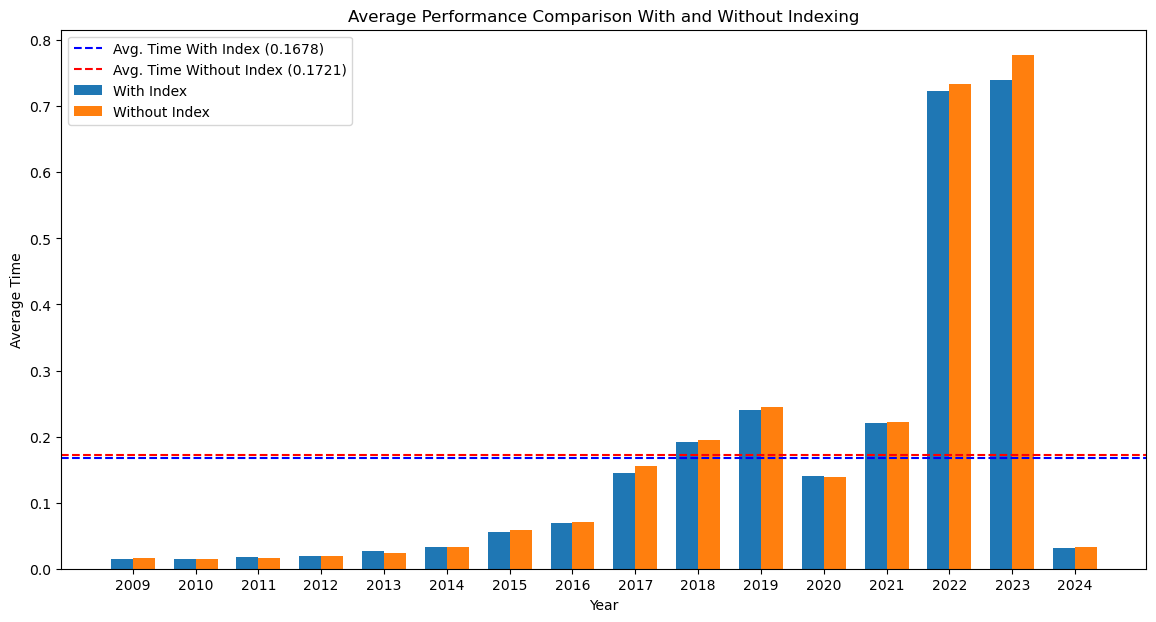

In [22]:
# Plot to compare the performances with and without indexes with respect to average time

plt.figure(figsize=(14, 7))
index = range(len(df_with_index))
bar_width = 0.35

plt.bar(index, df_with_index['avg'], bar_width, label='With Index')
plt.bar([p + bar_width for p in index], df_without_index['avg'], bar_width, label='Without Index')

# Calculate and plot the average times for with_bm and without_bm
avg_time_with_index = df_with_index['avg'].mean()
avg_time_without_index = df_without_index['avg'].mean()

plt.axhline(y=avg_time_with_index, color='blue', linestyle='--', label=f'Avg. Time With Index ({avg_time_with_index:.4f})')
plt.axhline(y=avg_time_without_index, color='red', linestyle='--', label=f'Avg. Time Without Index ({avg_time_without_index:.4f})')

plt.xlabel('Year')
plt.ylabel('Average Time')
plt.title('Average Performance Comparison With and Without Indexing')
plt.xticks([p + bar_width / 2 for p in index], df_with_index.index)
plt.legend()
plt.show()

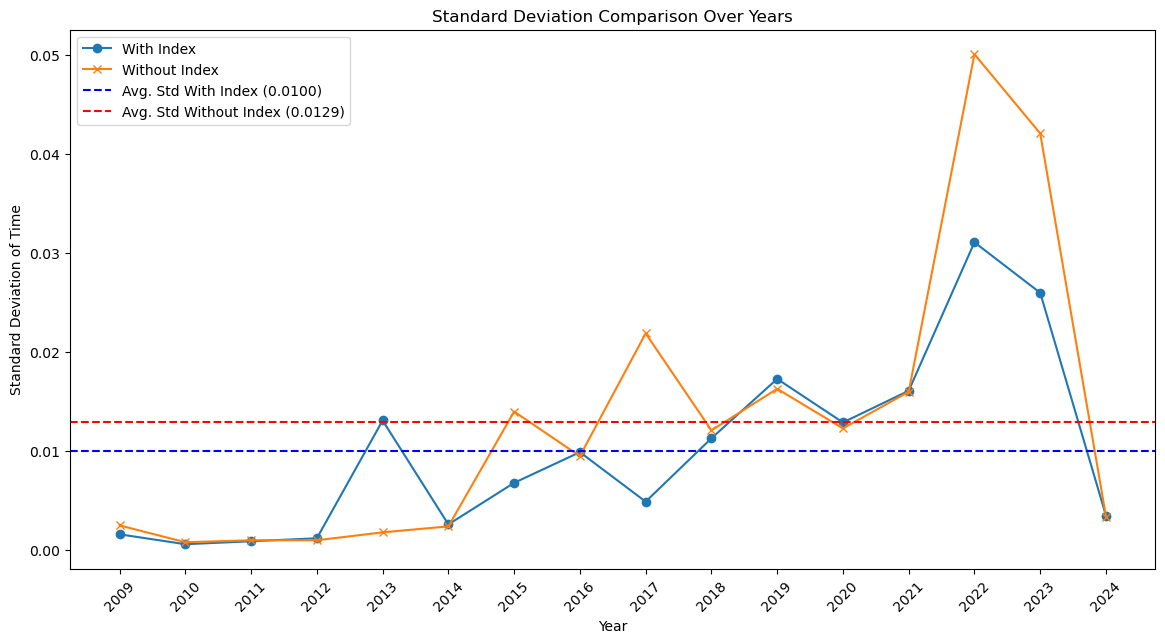

In [23]:
# Plot to compare the performances with and without indexes with respect to standard deviation

plt.figure(figsize=(14, 7))

# Plot standard deviations
plt.plot(df_with_index.index, df_with_index['std'], label='With Index', marker='o')
plt.plot(df_without_index.index, df_without_index['std'], label='Without Index', marker='x')

# Calculate and plot the average standard deviation for with_bm and without_bm
avg_std_with_index = df_with_index['std'].mean()
avg_std_without_index = df_without_index['std'].mean()

plt.axhline(y=avg_std_with_index, color='blue', linestyle='--', label=f'Avg. Std With Index ({avg_std_with_index:.4f})')
plt.axhline(y=avg_std_without_index, color='red', linestyle='--', label=f'Avg. Std Without Index ({avg_std_without_index:.4f})')

plt.xlabel('Year')
plt.ylabel('Standard Deviation of Time')
plt.title('Standard Deviation Comparison Over Years')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## <span style=color:blue>Using Prog Assgmt 2 json files for Visualization</span>

In [21]:
# Using the json files from PA 2 ---- listings_join_reviews (You can find this in the Files section under PROG-ASSGMT-2)

# Load JSON data from a file
with open('perf_data/listings_join_reviews_on_mac_v02.json', 'r') as file:
    data_listings = json.load(file)

# Printing the loaded file
print(json.dumps(data_listings, indent=4, sort_keys=True))

{
    "listings_join_reviews_2009": {
        "__": {
            "avg": 0.3367,
            "exec_count": 50,
            "max": 3.7037,
            "min": 0.242,
            "std": 0.4821,
            "timestamp": "2024-05-10-18:31:16"
        },
        "__datetime_in_reviews__": {
            "avg": 0.0143,
            "exec_count": 50,
            "max": 0.0223,
            "min": 0.013,
            "std": 0.0014,
            "timestamp": "2024-05-10-18:31:18"
        },
        "__datetime_in_reviews__id_in_listings__": {
            "avg": 0.0144,
            "exec_count": 50,
            "max": 0.0176,
            "min": 0.0132,
            "std": 0.0008,
            "timestamp": "2024-05-10-18:31:31"
        },
        "__id_in_listings__": {
            "avg": 0.2337,
            "exec_count": 50,
            "max": 0.2685,
            "min": 0.219,
            "std": 0.0119,
            "timestamp": "2024-05-10-18:31:30"
        }
    },
    "listings_join_reviews_2010": {
 

In [22]:
# Renaming the keys
data_listings_renamed = util.rename_keys(data_listings)

pp.pprint(data_listings_renamed)

{   '2009': {   '__': {   'avg': 0.3367,
                          'exec_count': 50,
                          'max': 3.7037,
                          'min': 0.242,
                          'std': 0.4821,
                          'timestamp': '2024-05-10-18:31:16'},
                '__datetime_in_reviews__': {   'avg': 0.0143,
                                               'exec_count': 50,
                                               'max': 0.0223,
                                               'min': 0.013,
                                               'std': 0.0014,
                                               'timestamp': '2024-05-10-18:31:18'},
                '__datetime_in_reviews__id_in_listings__': {   'avg': 0.0144,
                                                               'exec_count': 50,
                                                               'max': 0.0176,
                                                               'min': 0.0132,
                   

In [23]:
# Extract the avg values for each key inside each year object
def extract_avg_values(data):
    avg_values = {}
    for year, details in data.items():
        avg_values[year] = {}
        for key, metrics in details.items():
            if 'avg' in metrics:
                avg_values[year][key] = metrics['avg']
    return avg_values

# Extract the avg values
avg_values = extract_avg_values(data_listings_renamed)

pp.pprint(avg_values)

# Map the keys to the custom labels
key_labels = {
    "__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__id_in_listings__": "id_index",
    "__datetime_in_reviews__id_in_listings__": "datetime_and_id_index"
}

# Prepare data for DataFrame
data_for_df = {label: [] for label in key_labels.values()}
data_for_df['Year'] = sorted(avg_values.keys())

for year in data_for_df['Year']:
    for key, label in key_labels.items():
        data_for_df[label].append(avg_values[year].get(key, None))

# Create DataFrame
df = pd.DataFrame(data_for_df)

# Set 'Year' as the index
df.set_index('Year', inplace=True)

# Display the DataFrame
print(df)

{   '2009': {   '__': 0.3367,
                '__datetime_in_reviews__': 0.0143,
                '__datetime_in_reviews__id_in_listings__': 0.0144,
                '__id_in_listings__': 0.2337},
    '2010': {   '__': 0.2415,
                '__datetime_in_reviews__': 0.0163,
                '__datetime_in_reviews__id_in_listings__': 0.0154,
                '__id_in_listings__': 0.2368},
    '2011': {   '__': 0.2488,
                '__datetime_in_reviews__': 0.0168,
                '__datetime_in_reviews__id_in_listings__': 0.0169,
                '__id_in_listings__': 0.2442},
    '2012': {   '__': 0.2493,
                '__datetime_in_reviews__': 0.02,
                '__datetime_in_reviews__id_in_listings__': 0.0193,
                '__id_in_listings__': 0.248},
    '2013': {   '__': 0.2447,
                '__datetime_in_reviews__': 0.0238,
                '__datetime_in_reviews__id_in_listings__': 0.0246,
                '__id_in_listings__': 0.2546},
    '2014': {   '__': 0.2651

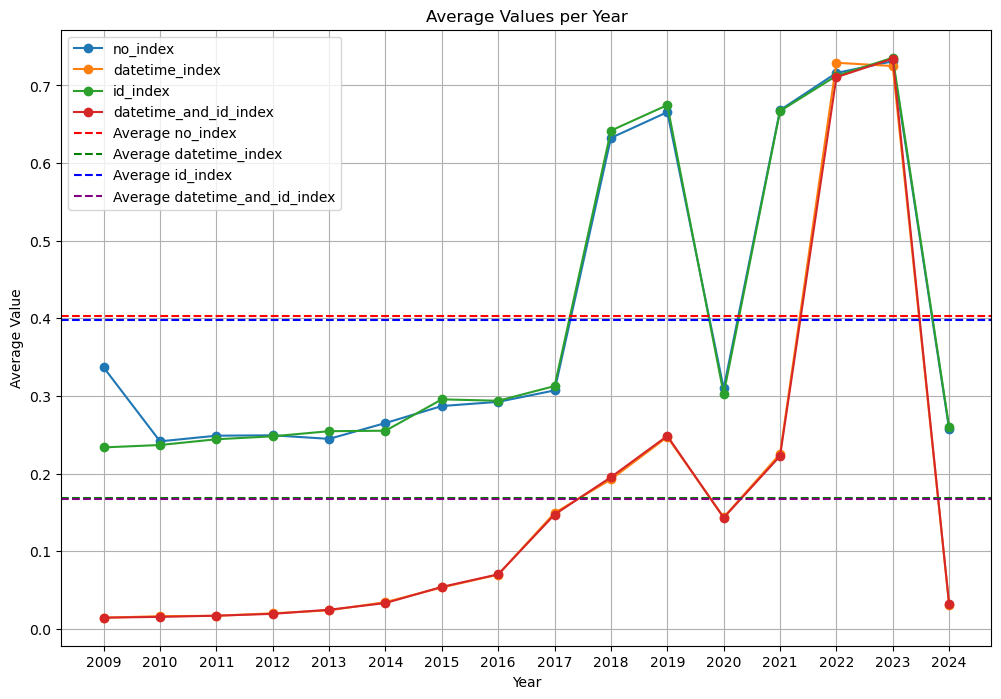

In [24]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(df.index, df[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot average lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    avg_value = df[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title('Average Values per Year')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()